In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
project_folder = r'/content/drive/MyDrive/Colab Notebooks/DeepLearning'
sys.path.insert(0, project_folder)

In [ ]:
import torch
import torch.nn as nn

#from MusicNet import MusicNet
import utils
from MusicNetManyhotNotes import MusicNet
from torchaudio import transforms
from torchvision import models
from os.path import join as path_join
from datetime import datetime
from torch.optim.lr_scheduler import StepLR 
# from dedicated_layers_model import get_model, train_single_layer
import dedicated_layers_model
from matplotlib import pyplot as plt

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
train_loader, val_loader, test_loader = utils.get_dataset_loaders()

loading cached metadata
loading cached metadata
loading cached metadata


In [ ]:
import importlib
importlib.reload(utils)
importlib.reload(dedicated_layers_model)

<module 'dedicated_layers_model' from '/content/drive/MyDrive/Colab Notebooks/DeepLearning/dedicated_layers_model.py'>

In [ ]:
base_model = models.resnet18(weights='DEFAULT')
base_model = base_model.requires_grad_(False)

# Training a single layer do detect instruments, using MSE loss
mse_model = dedicated_layers_model.get_model(base_model, train_loader.dataset.n_instruments)
mse_model = mse_model.to(device)
mse_model, mse_losses = dedicated_layers_model.train_single_layer(
    model=mse_model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    target='instrument', 
    loss_fn=torch.nn.MSELoss(), 
    device=device,
    predictor=utils.uniform_threshold_predictor,
    predictor_params=(0.6,),
    save_name_prefix='mse_loss',
    n_epochs=1)


# Training a single layer do detect instruments, using IoU loss
iou_model = dedicated_layers_model.get_model(base_model, train_loader.dataset.n_instruments)
iou_model = iou_model.to(device)
iou_model, iou_losses = dedicated_layers_model.train_single_layer(
    model=iou_model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    target='instrument', 
    loss_fn=utils.iou_loss, 
    device=device,
    predictor=utils.uniform_threshold_predictor,
    predictor_params=(0.6,),
    save_name_prefix='iou_loss',
    n_epochs=1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch - 0, batch - 100, loss - 0.17309421300888062
epoch - 0, batch - 200, loss - 0.12656356394290924
epoch - 0, batch - 300, loss - 0.0822797492146492
epoch - 0, batch - 400, loss - 0.07847879827022552
epoch - 0, batch - 500, loss - 0.08517695963382721
epoch - 0, batch - 600, loss - 0.05911118909716606
epoch - 0, batch - 700, loss - 0.0640074834227562
epoch - 0, batch - 800, loss - 0.08342483639717102
epoch - 0, batch - 900, loss - 0.21155676245689392
epoch - 0, batch - 1000, loss - 0.05269294232130051
epoch - 0, batch - 1100, loss - 0.04243382439017296
epoch - 0, batch - 1200, loss - 0.047511015087366104
epoch - 0, batch - 1300, loss - 0.054344139993190765
epoch - 0, batch - 1400, loss - 0.18851569294929504
epoch - 0, batch - 1500, loss - 0.04306221380829811
epoch - 0, batch - 1600, loss - 0.07928931713104248
epoch - 0, batch - 1700, loss - 0.1799452006816864
epoch - 0, batch - 1800, loss - 0.1537294238805771
epoch - 0, batch - 1900, loss - 0.048641107976436615
epoch - 0, batch - 200

In [ ]:
val_loader.dataset.all_metadata = val_loader.dataset.all_metadata.sort_values('csv_id').reset_index(drop=True)

In [ ]:
iou_val_results = []
mse_val_results = []
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
for threshold in thresholds:
    print(f'threshold {threshold}')
    iou_val_results.append(utils.get_test_score(
        test_loader=val_loader, 
        model=iou_model, 
        target='instrument', 
        predictor=utils.uniform_threshold_predictor, 
        predictor_params=(threshold,),
        device=device))
    print(f'iou loss = {iou_val_results[-1]}')
    mse_val_results.append(utils.get_test_score(
        test_loader=val_loader, 
        model=mse_model, 
        target='instrument', 
        predictor=utils.uniform_threshold_predictor, 
        predictor_params=(threshold,),
        device=device))
    print(f'mse loss = {mse_val_results[-1]}')
    

threshold 0.1
iou loss = (0.0, 0.8895145531214645, 3.66642)
mse loss = (0.0, 0.8155319003051185, 2.18542)
threshold 0.2
iou loss = (0.0, 0.828130892385752, 2.36678)
mse loss = (0.0, 0.777203538002674, 1.98296)
threshold 0.3
iou loss = (0.0, 0.8130292433748157, 2.13144)
mse loss = (0.0, 0.5766224416332407, 1.31388)
threshold 0.4
iou loss = (0.0, 0.8108951283897288, 2.10682)
mse loss = (0.0, 0.3719102471802256, 0.8082)
threshold 0.5
iou loss = (0.0, 0.787257019438445, 2.00626)
mse loss = (0.00646, 0.24467756865165072, 0.53418)
threshold 0.6
iou loss = (0.0, 0.6908104494497583, 1.66078)
mse loss = (0.02146, 0.21966814083444752, 0.49322)
threshold 0.7
iou loss = (0.0, 0.5535328602283246, 1.24412)
mse loss = (0.02234, 0.21809112413864035, 0.49128)


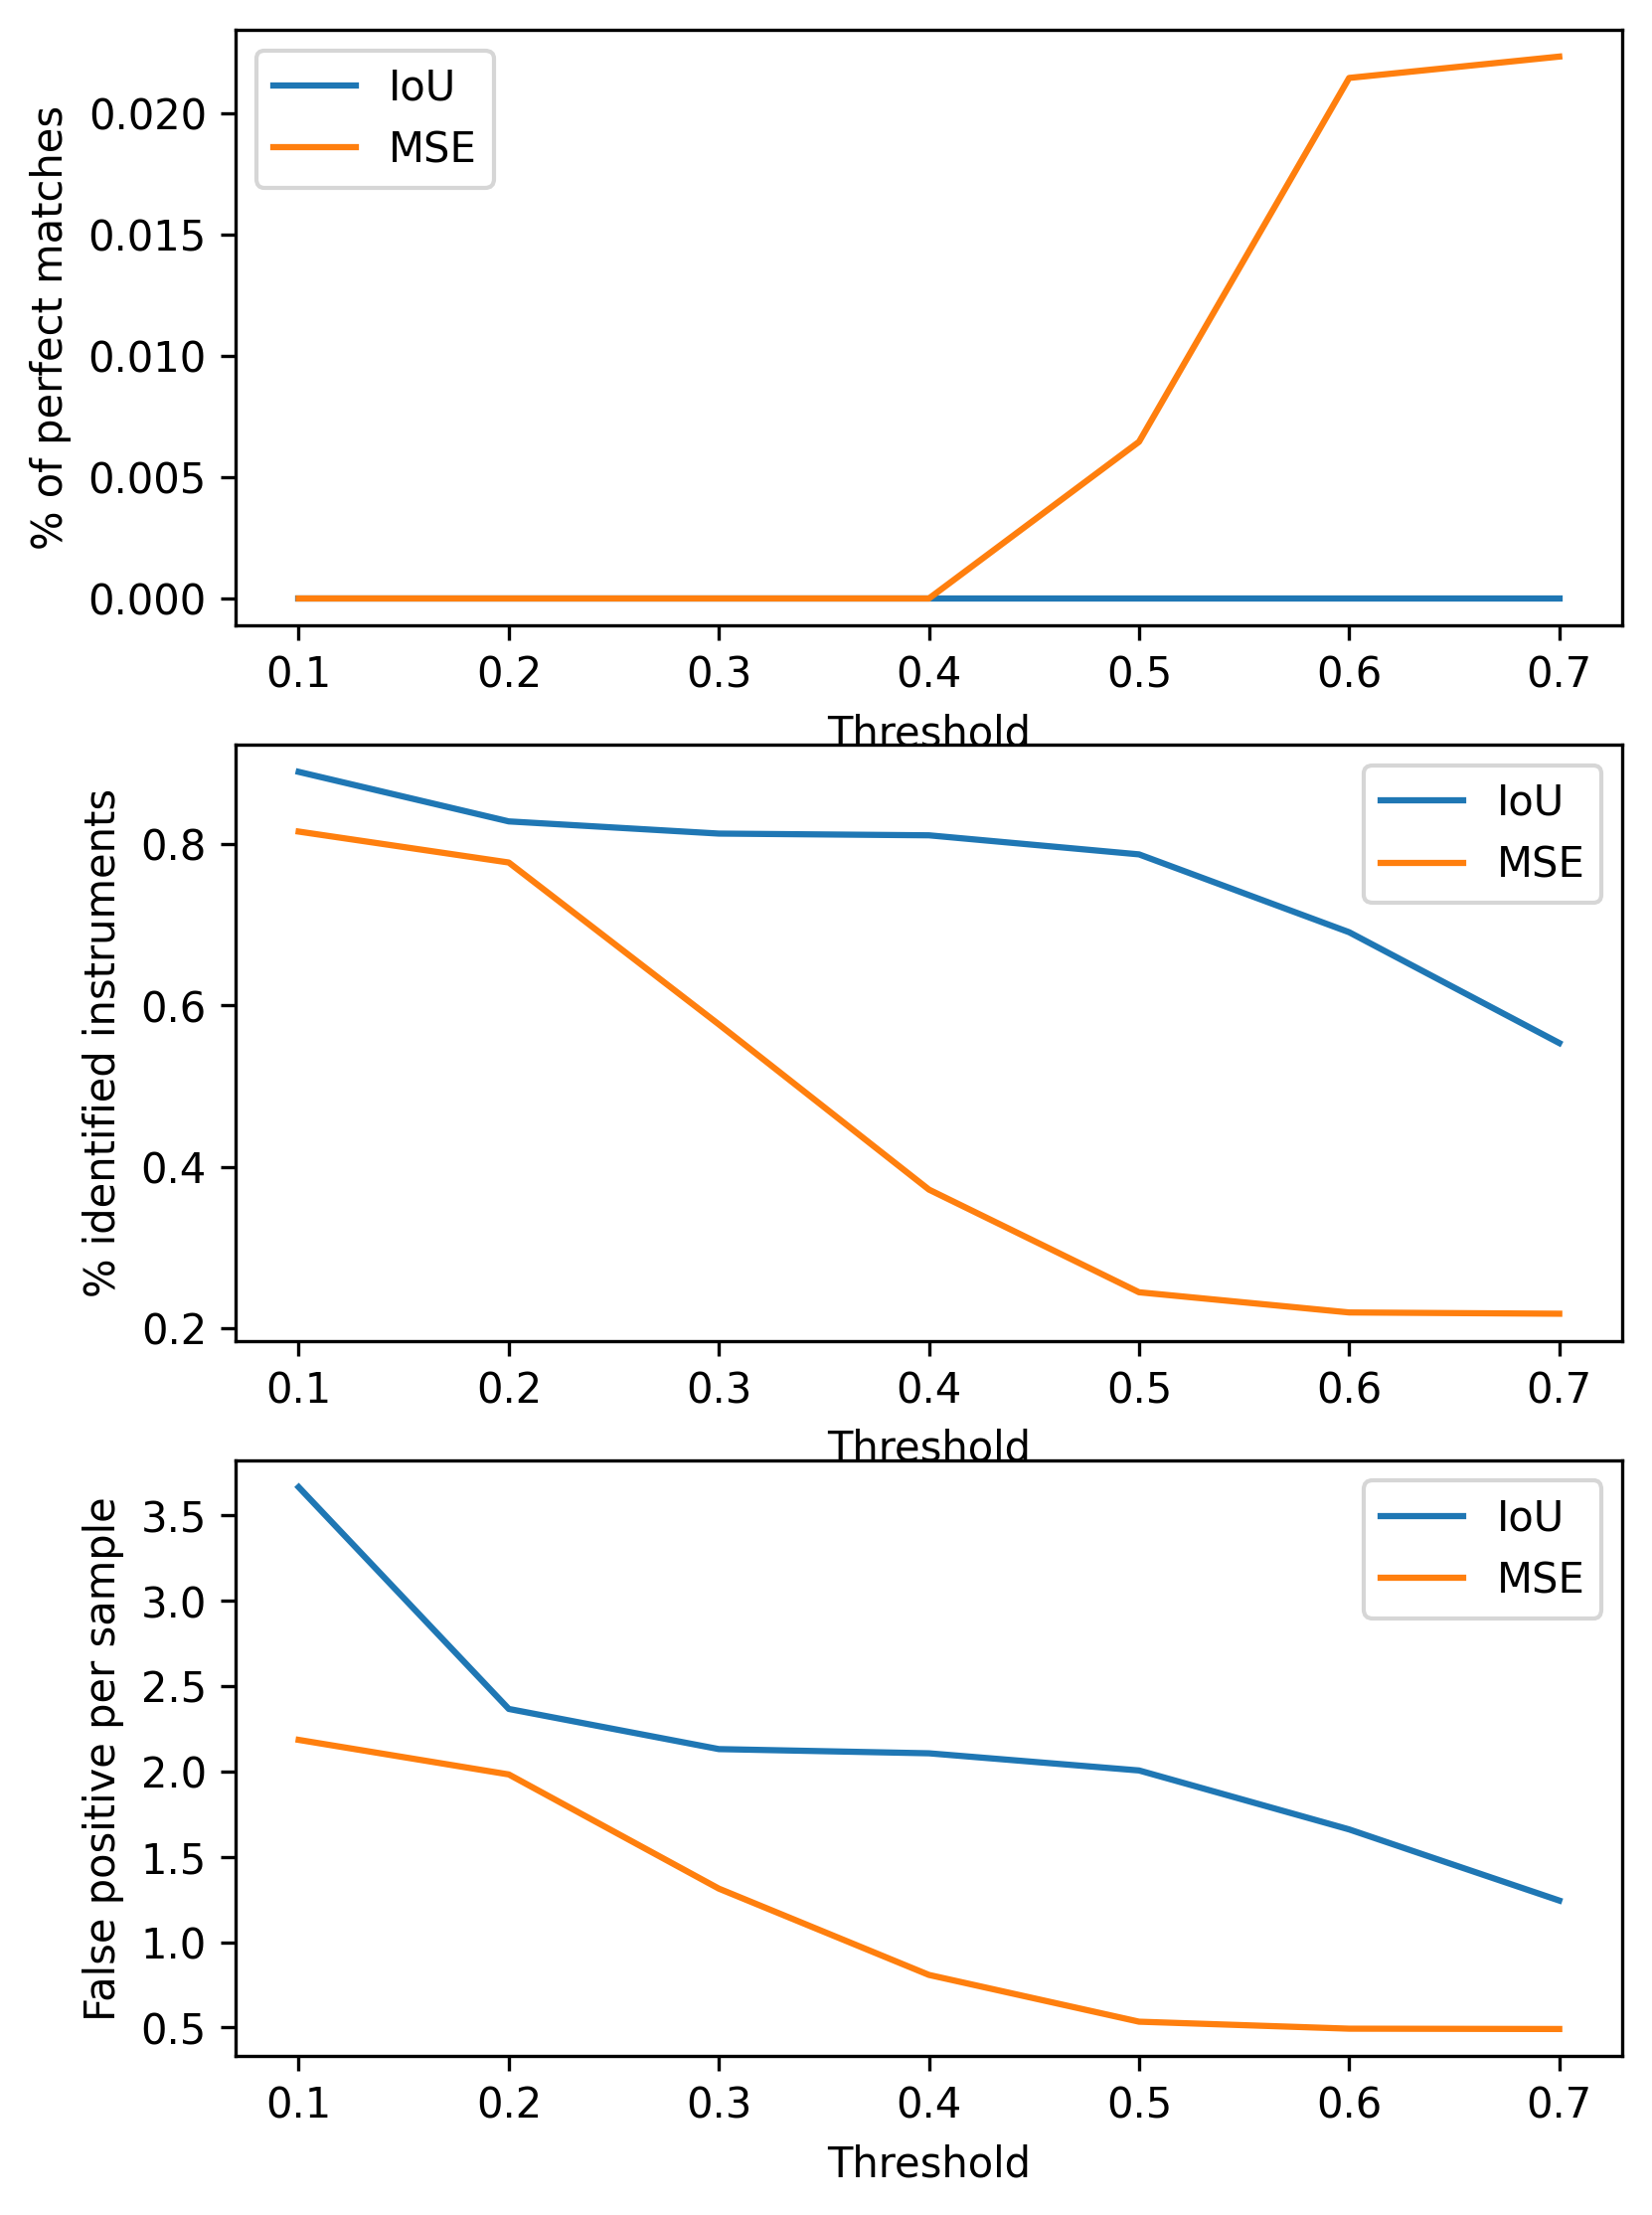

In [ ]:
plt.figure(figsize=(6,9), dpi=300)

plt.subplot(3,1,1)
plt.plot(thresholds, [i[0] for i in iou_val_results], label='IoU')
plt.plot(thresholds, [i[0] for i in mse_val_results], label='MSE')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('% of perfect matches')

plt.subplot(3,1,2)
plt.plot(thresholds, [i[1] for i in iou_val_results], label='IoU')
plt.plot(thresholds, [i[1] for i in mse_val_results], label='MSE')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('% identified instruments')

plt.subplot(3,1,3)
plt.plot(thresholds, [i[2] for i in iou_val_results], label='IoU')
plt.plot(thresholds, [i[2] for i in mse_val_results], label='MSE')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('False positive per sample')

plt.show()
